In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
import tail_estimation as te

In [2]:
!pwd

/Users/atharvajoshi/PycharmProjects/network_science


In [3]:
whole_network = pd.read_csv('/Users/atharvajoshi/Downloads/Northeastern/Network Science/whole_network.csv',header=None,index_col=[0])

In [4]:
whole_network

,1,2,3
0,,,
0,1292,257,16
1,1292,7420,36
2,1292,3048,332
3,1292,339,501
4,1292,19001,17
...,...,...,...
1634123,18834,235,1
1634124,31098,2707,4
1634125,31098,2709,2


In [5]:
cols = ['Source','Target','Weight']
whole_network.columns = cols

In [6]:
whole_graph = nx.from_pandas_edgelist(whole_network, source = 'Source', target = 'Target', edge_attr = 'Weight')

In [7]:
whole_graph.number_of_edges()

817064

In [8]:
whole_graph.number_of_nodes()

8372

In [9]:
nx.is_directed(whole_graph)

False

In [10]:
nx.is_connected(whole_graph)

False

In [11]:
largest_subgraph = max(nx.connected_components(whole_graph), key=len)

In [12]:
len(largest_subgraph)

8360

In [13]:
type(largest_subgraph)

set

In [14]:
gcc = whole_graph.subgraph(largest_subgraph)

In [15]:
nx.is_connected(gcc)

True

In [16]:
nx.is_directed(gcc)

False

In [17]:
def plot_degree(degree, number_of_bins=50, log_binning=True, base=2):
    """
    Given a degree sequence, return the y values (probability) and the
    x values (support) of a degree distribution that you're going to plot.
    
    Parameters
    ----------
    degree (np.ndarray or list):
        a vector of length N that corresponds to the degree, k_i, of every
        node, v_i, in the network

    number_of_bins (int):
        length of output vectors
    
    log_binning (bool)
        if you are plotting on a log-log axis, then this is useful
    
    base (int):
        log base, defaults to 2
        
    Returns
    -------
    x, y (np.ndarray):
        the support and probability values of the degree distribution
    
    """
    
    # We need to define the support of our distribution
    lower_bound = min(degree)
    upper_bound = max(degree)
    
    # And the bins
    if log_binning:
        log = np.log2 if base == 2 else np.log10
        lower_bound = log(lower_bound) if lower_bound >= 1 else 0.0
        upper_bound = log(upper_bound)
        bins = np.logspace(lower_bound,upper_bound,number_of_bins, base = base)
    else:
        bins = np.linspace(lower_bound,upper_bound,number_of_bins)
    
    # Then we can compute the histogram using numpy
    y, __ = np.histogram(degree, 
                         bins=bins,
                         density=True)
    # Now, we need to compute for each y the value of x
    x = bins[1:] - np.diff(bins)/2.0
        
    return x, y

In [18]:
degree_sequence = [d for n, d in gcc.degree()]

In [19]:
x, y = plot_degree(degree_sequence)

In [20]:
fit = powerlaw.Fit(degree_sequence, discrete=True)

Calculating best minimal value for power law fit
/Users/atharvajoshi/miniforge3/envs/ns_env/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/Users/atharvajoshi/miniforge3/envs/ns_env/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: divide by zero encountered in divide
  (CDF_diff**2) /


In [21]:
print(fit.power_law.alpha)
print(fit.power_law.xmin)
dists = ['power_law', 'lognormal']
R, p = fit.distribution_compare('power_law', 'lognormal')

2.345383868784098
299.0


/Users/atharvajoshi/miniforge3/envs/ns_env/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


In [22]:
print("if the R value is less than 0.0 (here, R = %.4f), then %s is preferred"%(R,dists[1]))

if the R value is less than 0.0 (here, R = -87.8630), then lognormal is preferred


In [23]:
random_benchmark1 = nx.erdos_renyi_graph(gcc.number_of_nodes(), p)
random1_degree_sequence  = plot_degree([d for n, d in random_benchmark1.degree()])

/var/folders/ny/dnkd838x2vd8ts_mzkyrxm8c0000gn/T/ipykernel_6921/1111185212.py:36: RuntimeWarning: divide by zero encountered in log2
  upper_bound = log(upper_bound)
/Users/atharvajoshi/miniforge3/envs/ns_env/lib/python3.9/site-packages/numpy/core/function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Users/atharvajoshi/miniforge3/envs/ns_env/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/Users/atharvajoshi/miniforge3/envs/ns_env/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


In [24]:
exponent = 2.345
# Solve for m using the rearranged equation
m = int((3 * exponent - 1) / (2 * exponent - 1))

# Create a Barabási-Albert graph with the calculated m
ba_model_ref = nx.barabasi_albert_graph(gcc.number_of_nodes(), m)

In [25]:
ba_model_degree_seq = plot_degree([d for n, d in ba_model_ref.degree()])

In [26]:
sum(degree_sequence)

1634116

In [27]:
avg_degree = sum(degree_sequence)/len(degree_sequence)

In [28]:
p = avg_degree/gcc.number_of_nodes()

In [30]:
# configuration model
config_model = nx.configuration_model(degree_sequence)
config_model = nx.Graph(config_model)
nx.degree_assortativity_coefficient(config_model)

In [59]:
theoretical_distribution = powerlaw.Power_Law(
    xmin=1, parameters=[fit.power_law.alpha], discrete=False
)

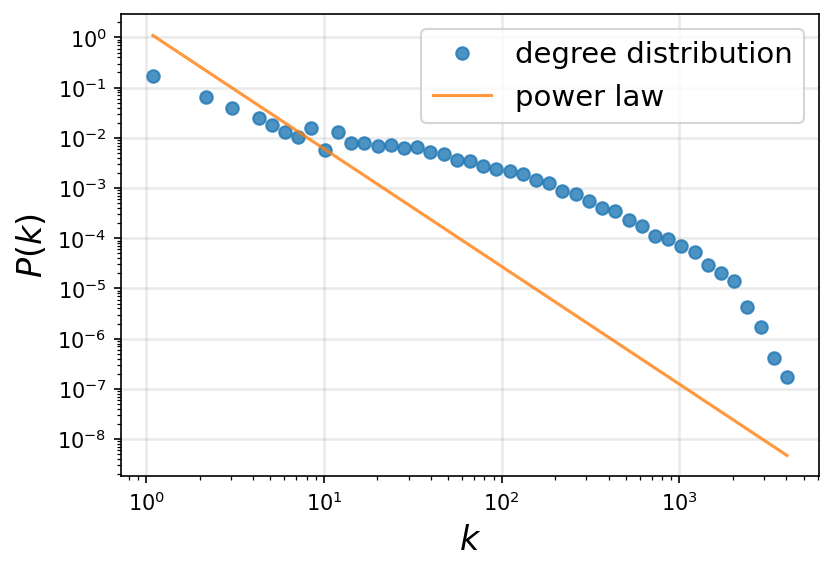

In [82]:
fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=150)

ax.loglog(x, y,'o', label='degree distribution', alpha=0.8)
ax.loglog(x, y_power,'-', label='power law', alpha=0.8)
#ax.loglog(random1_degree_sequence[0], random1_degree_sequence[1],'-', label=f'random network p = {p:0.3f}', alpha=0.8, color = 'r')
#ax.loglog(ba_model_degree_seq[0], ba_model_degree_seq[1],'o', label='degree distribution ba', alpha=0.8)

ax.set_xlabel(r"$k$", fontsize=16)
ax.set_ylabel(r"$P(k)$", fontsize=16)

ax.legend(fontsize=14)

ax.grid(linewidth=1.25, color='#999999', alpha=0.2, linestyle='-')
#plt.savefig('../figs/pngs/PolBlogs_inout_degreedist.png', dpi=425, bbox_inches='tight')
plt.show()

In [31]:
# degree assortatovity coefficient
nx.degree_assortativity_coefficient(gcc)

-0.19388633192885202

In [83]:
# structural cutoff at (<k>*N)**0.5
ks =((sum(degree_sequence)/len(degree_sequence))*len(degree_sequence))**0.5
print(ks)


1278.325467163977


In [84]:
max(degree_sequence)

4374

In [85]:
U = gcc.copy()

In [89]:
ks

1278.325467163977

In [90]:
cutoff_nodes = [v for v,d in list(U.degree()) if v>ks]


In [91]:
len(cutoff_nodes)

7295

In [92]:
gcc.number_of_nodes()

8360

In [ ]:
def graph_structural_cutoff(G):
    '''take a graph. compute its degree sequence. compute structural cutoff. 
    check for structural disassortativity by comparing to max degree seq. 
     if there, create a copy graph. remove nodes above cutoff limit and then check for disassorativity'''
    U = G.copy()
    f

In [61]:
max_degree = max(deg for n, deg in gcc.degree)
mapping = {x: x for x in range(max_degree + 1)} # identity mapping
mix_mat = nx.degree_mixing_matrix(gcc, mapping=mapping)

In [63]:
mix_mat.shape

(4375, 4375)

In [62]:
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.22390332e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.22390332e-06, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.22390332e-06],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.22390332e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])